In [30]:
import torch
import torch.utils.data
import torchvision.datasets as datasets
import os
import struct
import gzip
import errno
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
import torch.nn as nn
import torch.nn.functional as F
from torchnet import meter
import time

In [31]:
# <api>
# https://github.com/albu/albumentations
from albumentations import (ToFloat, Resize,
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose
)

In [3]:
# <api>
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [4]:
class AirbusDS_train(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path_train, aug, transform, ids, masks):
        """ Intialize the dataset
        """
        self.aug = aug
        self.path_train = path_train
        self.transform = transform
        self.df = ids
        self.masks = masks       
        self.filenames = self.df['ImageId'].values
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def get_mask(self, ImageId):
        img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        if img_masks == [-1]:
            return all_masks
        for mask in img_masks:
            all_masks += rle_decode(mask)
        return all_masks
    
    def get_label(self, ImageId):
        '''Returns a label: 0 - no ship, 1 - has one or more ships.'''
        label = int(self.df[self.df['ImageId']==ImageId]['has_ship'].values[0])
        return label
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_train + self.filenames[index]))
        ImageId = self.filenames[index]
        label = self.get_label(ImageId)
        mask = self.get_mask(ImageId)            
        if self.aug:
            data = {"image": np.array(image), "mask": mask}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            return image, transformed['mask'][np.newaxis,:,:], label
        else:
        
            return self.transform(image), mask[np.newaxis,:,:], label 

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [5]:
# <api>
class AirbusDS_val(AirbusDS_train):
    """
    A customized data loader.
    """
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_train + self.filenames[index]))
        ImageId = self.filenames[index]
        label = self.get_label(ImageId)
                    
        if self.aug:
            data = {"image": np.array(image)}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            return image, label
        else:
            return self.transform(image), label

In [6]:
class AirbusDS:
    """
    

    Parameters:
        args (dict): Dictionary of (command line) arguments.
            Needs to contain batch_size (int) and workers(int).
        is_gpu (bool): True if CUDA is enabled.
            Sets value of pin_memory in DataLoader.

    Attributes:
        trainset (torch.utils.data.TensorDataset): Training set wrapper.
        valset (torch.utils.data.TensorDataset): Validation set wrapper.
        train_loader (torch.utils.data.DataLoader): Training set loader with shuffling.
        val_loader (torch.utils.data.DataLoader): Validation set loader.
    """

    def __init__(self, is_gpu, batch_size, workers, root, \
                 aug=False, resize_factor=1, empty_frac=0.33, test_size=0.1):
        
        self.root = root
        self.path_train = root + 'train/'
        self.aug = aug
        self.empty_frac = empty_frac
        self.resize_factor = resize_factor
        self.test_size = test_size
        
        exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images   
    
        # Calculate masks
        masks = pd.read_csv(str(self.root+'train_ship_segmentations.csv')).fillna(-1)
        masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
        
        # Calculate the number of ships on the images
        unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
        unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
        unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
        
        # Drop corrupted images
        unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
        self.images_df = unique_img_ids
        
        masks.drop(['ships'], axis=1, inplace=True)
        self.masks = masks 
        
        ##########################

        self.trainset, self.valset = self.get_dataset()

        self.train_loader, self.val_loader = self.get_dataset_loader (batch_size, workers, is_gpu)

        self.val_loader.dataset.class_to_idx = {'no_ship': 0, 'ship': 1}


    def get_dataset(self):
        """
        Loads and wraps training and validation datasets

        Returns:
             torch.utils.data.TensorDataset: trainset, valset
        """
        
        # Split dataset to train and validate sets to evaluate the model
        train_ids, val_ids = train_test_split(self.images_df, test_size=test_size)
        self.val_ids = val_ids
        
        # Drop small images (mostly just clouds, water or corrupted)
        train_ids['file_size_kb'] = train_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(self.path_train, c_img_id)).st_size/1024)
        train_ids = train_ids[train_ids['file_size_kb']>40] # keep only >40kb files
        
        # Undersample empty images to balance the dataset
        ships = train_ids[train_ids['has_ship']==1] 
        no_ships = train_ids[train_ids['has_ship']==0].sample(frac=self.empty_frac)  # Take only this fraction of empty images
        self.train_ids = pd.concat([ships, no_ships], axis=0)        
               
        
        # Define transformations for augmentation and without it
        self.transform_no_aug = transforms.Compose([transforms.Resize((int(768/resize_factor), int(768/resize_factor))),
                                                 transforms.ToTensor()])
        if self.aug:
            self.transform = Compose([Resize(height=int(768/resize_factor), width=int(768/resize_factor)),
                                      OneOf([RandomRotate90(), Transpose(), Flip()], p=0.3)])
        else:
            self.transform = self.transform_no_aug

        # TensorDataset wrapper
        trainset = AirbusDS_train(self.path_train, self.aug, self.transform, self.train_ids, self.masks)
        valset = AirbusDS_val(self.path_train, False, self.transform_no_aug, self.val_ids, self.masks) 

        return trainset, valset

    def get_dataset_loader(self, batch_size, workers, is_gpu):
        """
        Defines the dataset loader for wrapped dataset

        Parameters:
            batch_size (int): Defines the batch size in data loader
            workers (int): Number of parallel threads to be used by data loader
            is_gpu (bool): True if CUDA is enabled so pin_memory is set to True

        Returns:
             torch.utils.data.TensorDataset: trainset, valset
        """

        train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True,
                                                   num_workers=workers, pin_memory=is_gpu, sampler=None)
        test_loader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=True,
                                                  num_workers=workers, pin_memory=is_gpu, sampler=None)

        return train_loader, test_loader


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_gpu = torch.cuda.is_available()
batch_size = 8
workers = 4
path = '../airbus/'
aug=True
resize_factor=4
empty_frac=0.3
test_size=0.1
    
dataset = AirbusDS(torch.cuda.is_available(), batch_size, workers, \
                   path, aug, resize_factor, empty_frac, test_size)

/home/mo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*45*45, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*45*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class CNN_fashion(nn.Module):
    def __init__(self, num_classes):
        super(CNN_fashion, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 5) # input features, output features, kernel size
        self.act1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.conv2 = nn.Conv2d(32, 64, 5) # input features, output features, kernel size
        self.act2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.fc = nn.Linear(64*45*45, num_classes) # 4x4 is the remaining spatial resolution here

    def forward(self, x):
        x = self.mp1(self.act1(self.conv1(x)))
        x = self.mp2(self.act2(self.conv2(x)))
        # The view flattens the output to a vector (the representation needed by the classifier)
        x = x.view(-1, 64*45*45)
        x = self.fc(x)
        return x

### Defining optimization criterion and optimizer
A good baseline is a Cross Entropy loss (Log Softmax + negative log-likelihood) and a stochastic gradient descent (SGD) algorithm with a baseline learning rate of 0.01. If we want to we can use additional momenta or regularization terms (such as L2 - Tikhonov regularization commonly reffered to as weight-decay in ML). 

In [10]:
# Define optimizer and loss function (criterion)
#model = CNN_fashion(2).to(device)
model = torch.load('CNN_fashion.model', map_location='cpu').to(device)
criterion = nn.CrossEntropyLoss().to(device)

# we can use advanced stochastic gradient descent algorithms 
# with regularization (weight-decay) or momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                            momentum=0.9,
                            weight_decay=5e-4)

### Monitoring and calculating accuracy
We add a convenience class to keep track and average concepts such as processing or data loading speeds, losses and accuracies. For this we need to define a function to define accuracy, which could be based on the absolute accuracy, or top-1 accuracy. Often times in Machine Learning other metrics are employed. For example, in the ImageNet ILSVRC challenge with a classification problem containing a 1000 classes, it is common to report the top-5 accuracy. Here a prediction is counted as accurate if the correct class lies within the top-5 most likely output classes. 

In [12]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(outputs, targets):
    """
    Evaluates a model's top k accuracy

    Parameters:
        outputs (torch.autograd.Variable): model output
        targets (torch.autograd.Variable): ground-truths/labels
        

    Returns:
        float: percentage of correct predictions
    """

    batch_size = targets.size(0)

    _, pred = torch.max(outputs.data, 1)
    correct = (pred == targets).sum().item()

    res = 100 * correct / batch_size
    return res

### Training function (sometimes referred to as "hook")
The training function needs to loop through the entire dataset in steps of mini-batches (for SGD). For each mini-batch the output of the model and losses are calculated and a "backward" pass is done in order to do an update to the model's weights. When the entire dataset has been processed once, one epoch of the training has been conducted. It is common to shuffle the dataset after each epoch. In this implementation this is handled by the "sampler" of the dataset loader. 

In [13]:
def train(train_loader, model, criterion, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_loader (torch.utils.data.DataLoader): The trainset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    for i, data in enumerate(train_loader):
        inputs, masks, targets = data
        inputs = inputs.to(device).float()
        targets = targets.to(device).long()
        

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        #prec1 = accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        #top1.update(prec1, inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if i % 1000 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(loss=losses))

### Validation function
Validation is similar to the training loop, but on a separate dataset with the exception that no update to the weights is performed. This way we can monitor the generalization ability of our model and check whether it is overfitting (memorizing) the training dataset.  

In [14]:
def validate(val_loader, model, criterion, device):
    """
    Evaluates/validates the model

    Parameters:
        val_loader (torch.utils.data.DataLoader): The validation or testset dataloader
        model (torch.nn.module): Model to be evaluated/validated
        criterion (torch.nn.criterion): Loss function
        device (string): cuda or cpu
    """

    losses = AverageMeter()
    top1 = AverageMeter()

    confusion = meter.ConfusionMeter(len(val_loader.dataset.class_to_idx), normalized=True)

    # switch to evaluate mode
    model.eval()

    for i, data in enumerate(val_loader):
        inputs, targets = data
        inputs = inputs.to(device).float()
        targets = targets.to(device).long()

        # compute output
        outputs = model(inputs)

        # compute loss
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1 = accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1, inputs.size(0))

        # add to confusion matrix
        confusion.add(outputs.data, targets)

    print(' * Validation accuracy: Prec@1 {top1.avg:.3f} '.format(top1=top1))
    print('Confusion matrix: ', confusion.value())

### Running the training of the model

In [32]:
total_epochs = 10
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1, time.strftime("%Y-%m-%d %H:%M:%S"))
    print("TRAIN")
    train(dataset.train_loader, model, criterion, optimizer, device)
    print("VALIDATION", time.strftime("%Y-%m-%d %H:%M:%S"))
    validate(dataset.val_loader, model, criterion, device)

EPOCH: 1
TRAIN
Loss 0.0813 (0.0813)	
Loss 0.2086 (0.5266)	
Loss 0.2873 (0.5148)	
Loss 0.4216 (0.5026)	
Loss 0.4520 (0.5017)	
Loss 0.7439 (0.5013)	
Loss 0.2928 (0.5003)	
Loss 0.2476 (0.5009)	
Loss 0.1594 (0.4987)	
Loss 0.4901 (0.4986)	
Loss 0.4262 (0.4962)	
Loss 0.6380 (0.4966)	
VALIDATION
 * Validation accuracy: Prec@1 82.262 
Confusion matrix:  [[7086  477]
 [1369 1475]]
Confusion matrix (norm.):  [[2362.          159.        ]
 [ 456.33333333  491.66666667]]
EPOCH: 2
TRAIN
Loss 0.5394 (0.5394)	
Loss 0.2643 (0.4962)	
Loss 0.3627 (0.4932)	
Loss 0.6023 (0.4948)	
Loss 0.7958 (0.4910)	
Loss 0.3527 (0.4886)	
Loss 1.0726 (0.4873)	
Loss 0.3250 (0.4910)	
Loss 0.2918 (0.4905)	
Loss 0.9821 (0.4918)	
Loss 0.3373 (0.4920)	
Loss 0.3173 (0.4929)	
VALIDATION
 * Validation accuracy: Prec@1 80.571 
Confusion matrix:  [[7131  432]
 [1590 1254]]
Confusion matrix (norm.):  [[2377.  144.]
 [ 530.  418.]]
EPOCH: 3
TRAIN
Loss 0.8006 (0.8006)	
Loss 0.5684 (0.5173)	
Loss 0.4313 (0.5463)	
Loss 0.7568 (0.5286)	

In [36]:
confus = np.array([[5815, 1748],[ 515, 2329]])

In [37]:
confus.T/len(dataset.valset)

array([[0.55875853, 0.04948592],
       [0.16796387, 0.22379168]])

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [12]:
#torch.save(model, '../CNN_fashion.model')

In [22]:
model.eval()
dataiter = iter(dataset.val_loader)
images, labels = dataiter.next()
images = images.to(device).float()
labels = labels.to(device).long()
outputs = model(images)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f417e5fbf98>>
Traceback (most recent call last):
  File "/home/mo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/mo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mo/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mo/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mo/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/mo/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c 

In [23]:
outputs

tensor([[-1.9437,  1.9237],
        [ 0.5406, -0.5406],
        [ 0.5404, -0.5404],
        [ 0.5406, -0.5406],
        [-0.3009,  0.2973],
        [ 0.3921, -0.3985],
        [-1.2477,  1.2324],
        [ 0.5653, -0.5647]], grad_fn=<ThAddmmBackward>)

In [24]:
torch.max(outputs.data, 1)

(tensor([1.9237, 0.5406, 0.5404, 0.5406, 0.2973, 0.3921, 1.2324, 0.5653]),
 tensor([1, 0, 0, 0, 1, 0, 1, 0]))

In [25]:
labels

tensor([1, 0, 1, 0, 0, 1, 0, 0])

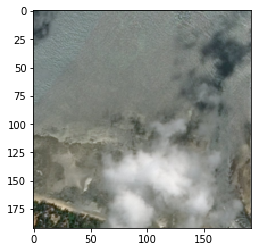

In [28]:
imshow(images[5])

In [36]:
time.strftime("%Y-%m-%d %H:%M:%S")

'2018-09-12 11:30:34'